In [2]:
import numpy as np
import matplotlib.pyplot as plt
from imaids.models import Kyma22
from idanalysis import IDKickMap
from scipy.optimize import curve_fit
import sympy
FOLDER_DATA = './results/model/data/'

In [3]:
def get_phase_str(gap):
    """."""
    phase_str = '{:+07.3f}'.format(gap).replace('.', 'p')
    phase_str = phase_str.replace('+', 'pos').replace('-', 'neg')
    return phase_str


def get_kmap_filename(phase):
    fpath = FOLDER_DATA + 'kickmaps/'
    fpath = fpath.replace('model/data/', 'model/')
    phase_str = get_phase_str(phase)
    fname = fpath + 'kickmap-papu50-phase.txt'.format(
        phase_str)
    return fname


def get_termination_kicks(fname):
    idkmap = IDKickMap(kmap_fname=fname)
    kickx_up = idkmap.kickx_upstream  # [T².m²]
    kicky_up = idkmap.kicky_upstream  # [T².m²]
    kickx_down = idkmap.kickx_downstream  # [T².m²]
    kicky_down = idkmap.kicky_downstream  # [T².m²]
    termination_kicks = [kickx_up, kicky_up, kickx_down, kicky_down]
    return termination_kicks

In [4]:
def generate_radia_model(phase, width):
    """."""
    nr_periods = 5

    block_shape =  [[
                    [width/2 - 3, 0], [width/2, -3], 
                    [width/2, -17], [width/2 -3, -20],
                    [-width/2 + 3, -20], [-width/2, -17],
                     [-width/2, -3], [-width/2 + 3, 0]]]
                     
    kyma = Kyma22(nr_periods=nr_periods)
    kyma.dp = phase

    return kyma

In [5]:
def get_field_on_axis(kyma, rz, y, x, plot_flag=True):
    field = kyma.get_field(x, y, rz)
    bx = field[:, 0]
    by = field[:, 1]
    bz = field[:, 2]

    if plot_flag:
        plt.plot(rz, bx, label='Bx')
        plt.plot(rz, by, label='By')
        plt.plot(rz, bz, label='Bz')
        plt.xlabel('rz [mm]')
        plt.ylabel('Field [T]')
        plt.legend()
        plt.grid()
        plt.show()

    return bx, by, bz

In [6]:
def get_field_roll_off(kyma, rx, peak_idx, x=0, y=0, plot_flag=True, component='y'):
    """."""
    if component=='y':
        fidx = 1
    elif component=='z':
        fidx = 2 
    else:
        fidx = 0
    period = kyma.period_length
    rz = np.linspace(-period/2, period/2, 100)
    field = kyma.get_field(x, y, rz)
    by = field[:, fidx]
    by_max_idx = np.argmax(by)
    rz_at_max = rz[by_max_idx] + peak_idx*period
    field = kyma.get_field(rx, y, rz_at_max)
    by = field[:, fidx]
    rx5_idx = np.argmin(np.abs(rx - 5))
    rx0_idx = np.argmin(np.abs(rx))
    roff = np.abs(by[rx5_idx]/by[rx0_idx]-1)
    print('roll off = ', 100*roff, '%')
    if plot_flag:
        plt.plot(rx, by)
        plt.xlabel('x [mm]')
        plt.ylabel('Bz [T]')
        plt.title('Field rolloff at x = 5 mm')
        plt.grid()
        plt.show()

    return by

In [7]:
def get_field_roll_off_vertical(kyma, ry, peak_idx=0, x=0, y=0, plot_flag=False, component='y'):
    """."""
    if component=='y':
        fidx = 1
    elif component=='z':
        fidx = 2 
    else:
        fidx = 0
    period = kyma.period_length
    rz = np.linspace(-period/2, period/2, 100)
    field = kyma.get_field(x, y, rz)
    by = field[:, fidx]
    by_max_idx = np.argmax(by)
    rz_at_max = rz[by_max_idx] + peak_idx*period
    field = kyma.get_field(x, ry, rz_at_max)
    by = field[:, fidx]
    if plot_flag:
        plt.plot(ry, by)
        plt.xlabel('x [mm]')
        plt.ylabel('Bz [T]')
        plt.title('Vertical dependence')
        plt.grid()
        plt.show()
    
    print('zmax = {:.2f}'.format(rz_at_max))
    return by

In [8]:
rz = np.linspace(-100, 100, 801)
rx = np.linspace(-10, 10, 4*81)
ry = np.linspace(-3, 3, 25)

In [9]:
width=5
kyma = generate_radia_model(phase=0, width=width)
kyma.solve()
# for block in kyma.cassettes_ref['cs'].blocks:
    # block.magnetization = ([1e-9, 0, 0])
# for block in kyma.cassettes_ref['ci'].blocks:
    # block.magnetization = ([1e-9, 0, 0])
# mag_dict = kyma.magnetization_dict
# print(mag_dict)
# kyma.create_radia_object(magnetization_dict=mag_dict)


[1.3951185887389199e-06, 1.3220494332639223, 1.3504300788600148, 3.0]

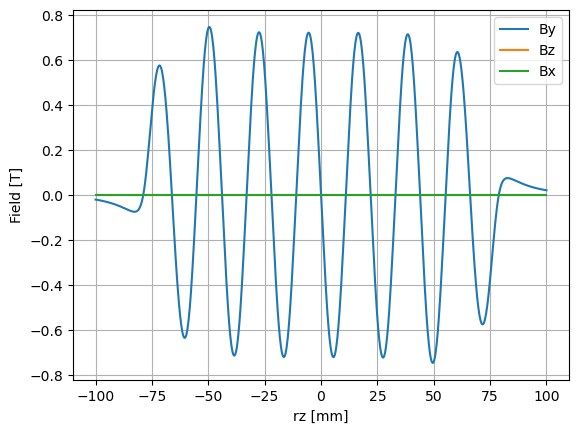

In [10]:
kyma.dp = 0
bx, by, bz = get_field_on_axis(kyma, rz, x=0, y=0, plot_flag=False)
# plt.plot(rz, bx, label='Bx')
plt.plot(rz, by, label='By')
plt.plot(rz, bz, label='Bz')
plt.plot(rz, bx, label='Bx')
plt.xlabel('rz [mm]')
plt.ylabel('Field [T]')
plt.legend()
plt.grid()
plt.show()


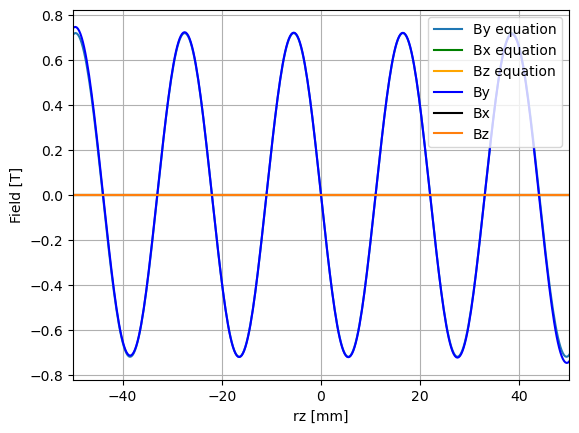

In [14]:
period = 22
width = 30
dp = 0
eta = 11.65
y=0
x=0
kyma.dp = dp
bx, by, bz = get_field_on_axis(kyma, rz, x=x, y=y, plot_flag=False)
b0 = 0.72
kz = 2*np.pi/period
kx = 2*np.pi/(eta*width)
ky = np.sqrt(kx**2+kz**2)
by_eq = -b0/2*np.cos(kx*x)*(np.exp(-ky*y)*np.sin(kz*rz)+np.exp(ky*y)*np.sin(kz*rz-kz*dp))
bx_eq = -kx/ky*b0/2*np.sin(kx*x)*(np.exp(-ky*y)*np.sin(kz*rz)-np.exp(ky*y)*np.sin(kz*rz-kz*dp))
bz_eq = kz/ky*b0/2*np.cos(kx*x)*(np.exp(-ky*y)*np.cos(kz*rz)-np.exp(ky*y)*np.cos(kz*rz-kz*dp))

plt.plot(rz, by_eq, color='C0', label='By equation')
plt.plot(rz, bx_eq, color='g', label='Bx equation')
plt.plot(rz, bz_eq, color='orange', label='Bz equation')
plt.plot(rz, by, color='b', label='By')
plt.plot(rz, bx, color='k', label='Bx')
plt.plot(rz, bz, color='C1', label='Bz')
plt.xlabel('rz [mm]')
plt.ylabel('Field [T]')
plt.xlim(-50, 50)
plt.legend()
plt.grid()
plt.show()

zmax = 0.11
0.7353302535250162
0.27957974224720666
-0.00012421209443049666


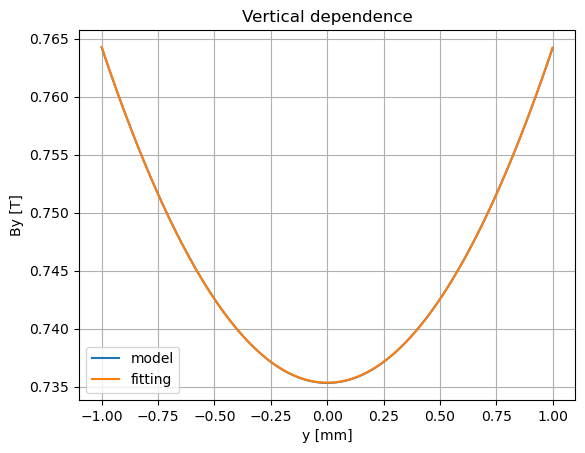

In [248]:
def hiperbolic_cos(x, b0, ky, phi):
    b = b0*np.cosh(ky*x + phi)
    return b

phases = [11]
for dp in phases:
    kyma.dp = dp
    by = get_field_roll_off_vertical(kyma, ry, x=0, peak_idx=0, plot_flag=False, component='z')
    opt = curve_fit(hiperbolic_cos, ry, by)[0]
    print(opt[0])
    print(opt[1])
    print(opt[2])
    b_fitted = hiperbolic_cos(ry, opt[0], opt[1], opt[2])
    plt.plot(ry, by, label='model')
    plt.plot(ry, b_fitted, label='fitting')
    plt.xlabel('y [mm]')
    plt.ylabel('By [T]')
    plt.title('Vertical dependence')
    plt.grid()
    plt.legend()

plt.show()






roll off =  0.017832776594828292 %
0.7216694449199137
0.018869749102821423


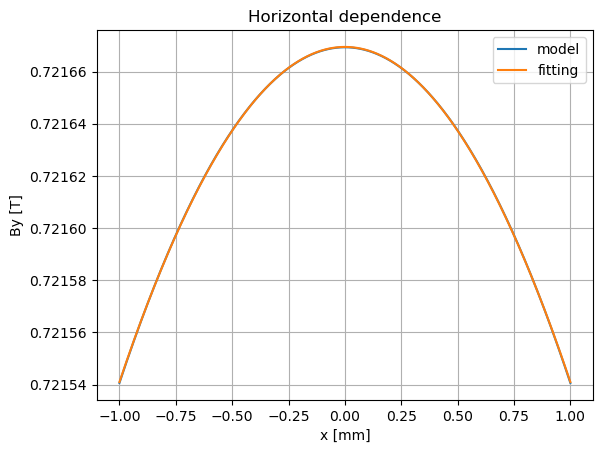

In [17]:
kxl = list()
phil = list()
def cos(x, b0, kx):
    b = b0*np.cos(kx*x)
    return b
phases = [0]
rx = np.linspace(-1, 1, 1000)
for dp in phases:
    kyma.dp = dp
    by = get_field_roll_off(kyma, rx, y=0, peak_idx=0, plot_flag=False, component='y')
    opt = curve_fit(cos, rx, by)[0]
    print(opt[0])
    print(opt[1])
    b_fitted = cos(rx, opt[0], opt[1])
    plt.plot(rx, by, label='model')
    plt.plot(rx, b_fitted, label='fitting')
    plt.xlabel('x [mm]')
    plt.ylabel('By [T]')
    plt.title('Horizontal dependence')
    plt.grid()
    plt.legend()
    

In [29]:
import numpy as np
import matplotlib.pyplot as plt
period = 22
b = 0.72
l = 1.3
R = 10
kz = 2*np.pi/(period*1e-3)
# roff31 = 0.0028
# roff64 = 0.0002
# roffs = np.linspace(0.0002, 0.02)
kx = 0.01887*1e3
ky = np.sqrt(kx**2+kz**2)

a = (1/kz**2)*l*(b**2)/(2*R**2)
coefx = a*kx**2
coefy = -a*ky**2

print(coefx)
print(coefy)




1.4709834101862856e-05
-0.0033843098341018625
